# AIN429 - Data Mining Laboratory
## Instructor: Suat Özdemir
## Assistant: Ahmet Alkılınç
## Subject: Clustering
## Student Info: Can Ali Ateş
## Student ID: 2200765002

# Importing Libraries and Dataset

In [ ]:
# Import Necessary Libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch

In [ ]:
# Import the dataset.
df = pd.read_csv('data.csv', delimiter = ";")

# Display the data frame shape.
print(f'Data Frame Shape: {df.shape}\n')

# Display the first 5 record of data frame.
df.head()

Data Frame Shape: (846, 18)



,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183


# Data Preprocessing & Analysis

In [ ]:
# Get the column types information before preprocessing steps.
df.dtypes

compactness                      int64
circularity                    float64
distance_circularity           float64
radius_ratio                   float64
pr.axis_aspect_ratio           float64
max.length_aspect_ratio          int64
scatter_ratio                  float64
elongatedness                  float64
pr.axis_rectangularity         float64
max.length_rectangularity        int64
scaled_variance                float64
scaled_variance.1              float64
scaled_radius_of_gyration      float64
scaled_radius_of_gyration.1    float64
skewness_about                 float64
skewness_about.1               float64
skewness_about.2               float64
hollows_ratio                    int64
dtype: object

**The dataset contains numerical columns only, so we don't need to do any preprocessing operation for categorical columns.**

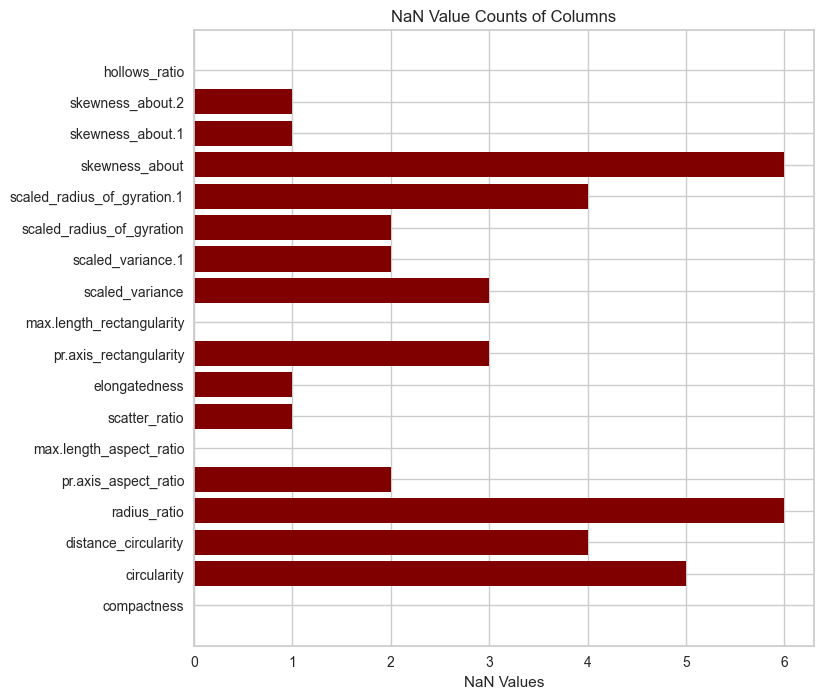

In [ ]:
# Create a barplot to display NaN counts of columns.
fig = plt.figure(figsize = (8, 8))
plt.barh(df.columns, df.isnull().sum(), color ='maroon')
plt.xlabel("NaN Values")
plt.title("NaN Value Counts of Columns")
plt.show()

**A Column contains at most 6 NaN values, so we don't need to use any learning algorithms to populate these NaN values because 6 NaN in 846 records is a very low percentage. I didn't check for outliers, so I'm going to populate these NaN values with median values instead of the mean because the mean can be affected by outliers.** 

In [ ]:
# Fill the NaN values of columns with the column median.
df = df.fillna(df.median())

# Check NaN values after filling them with median.
df.isnull().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
dtype: int64

**Clustering can easily affect from the outliers, so I have to check and deal with outliers as a continuation of missing value filling.**

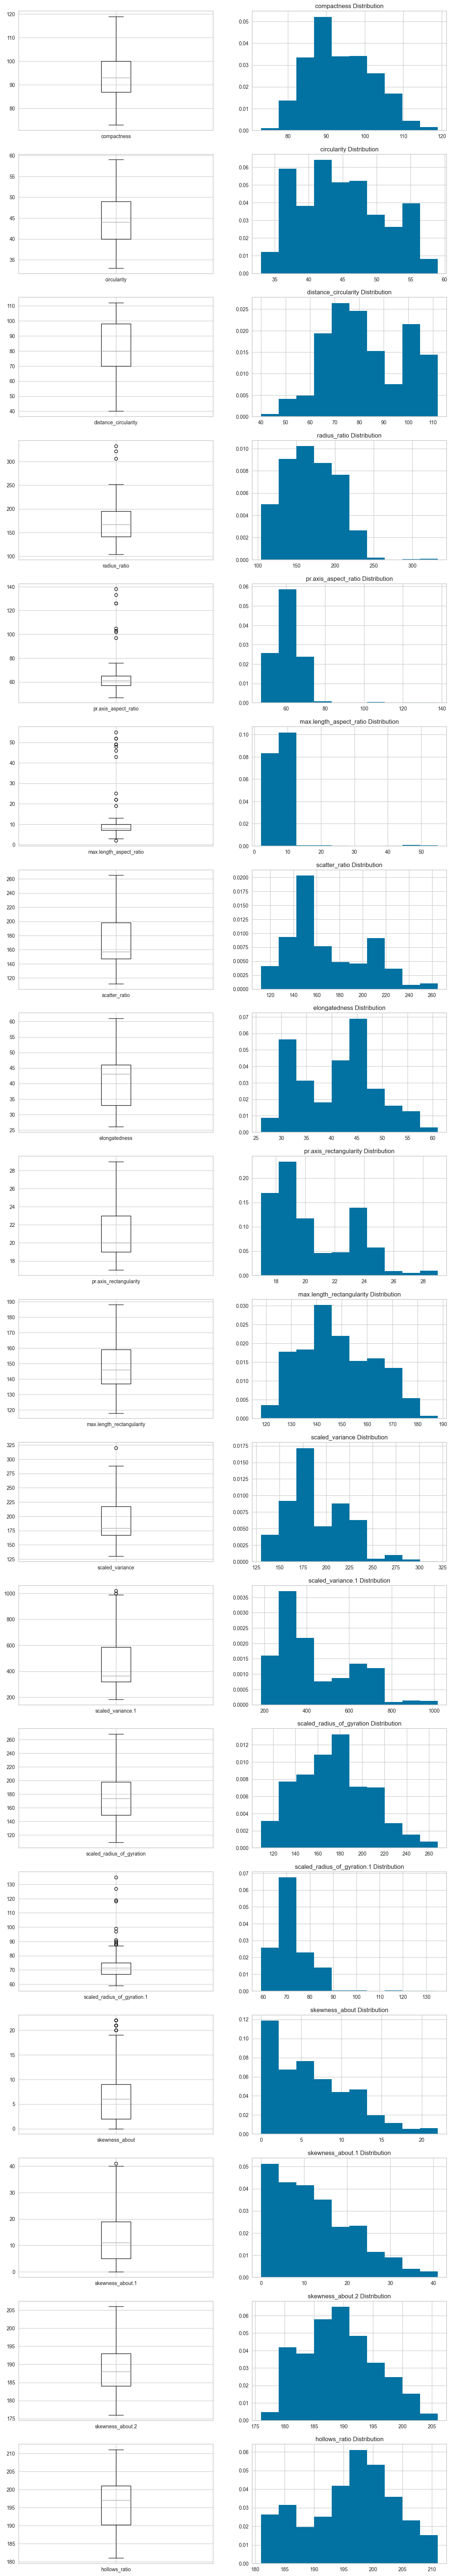

In [ ]:
# Create Boxplot and Histogram of each column to detect possible outliers.
plt.figure(figsize=(15, 90))
i = 0
for index, column in enumerate(df.columns):
    plt.subplot(18, 2, 2*index + 1)
    df.boxplot([column])
    plt.subplot(18, 2, 2*index + 2)
    plt.hist(df[column], density=True)
    plt.title(f'{column} Distribution')
    i += 2
plt.show()

**I evaluated the boxplots and histograms of each column, according to this evaluation:**
* radius_ratio 
* pr.axis_aspect_ratio
* max.length_aspect_ratio
* scaled_variance
* scaled_radius_of_gyration.1 

**features has certain outliers according to this evaluation. Therefore, I need to deal with these outliers.**

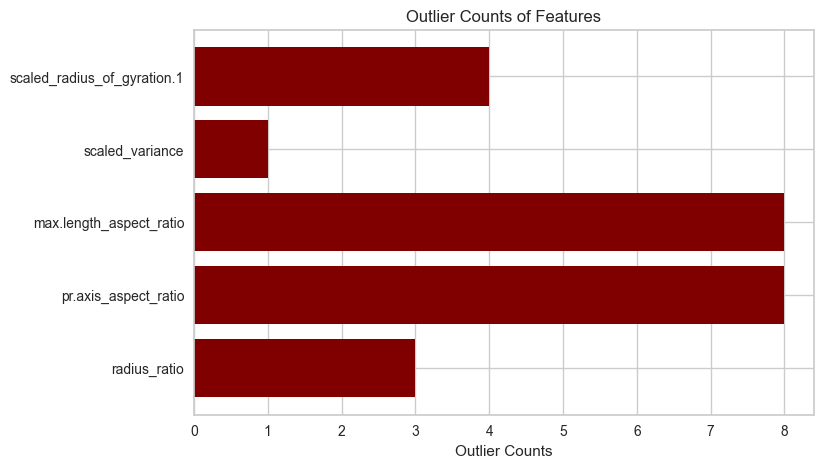

In [ ]:
# Calculate how many outliers for each column.
columns = ['radius_ratio', 'pr.axis_aspect_ratio', 'max.length_aspect_ratio', 'scaled_variance', 'scaled_radius_of_gyration.1']
bounds = [280, 90, 30, 300, 110]
outlier_counts = []

for column, value in zip(columns, bounds):
    outlier_counts.append(len(np.where(df[column] > value)[0]))
    
# Plot BarH to display the outlier count of each feature.
fig = plt.figure(figsize = (8, 5))
plt.barh(columns, outlier_counts, color ='maroon')
plt.xlabel("Outlier Counts")
plt.title("Outlier Counts of Features")
plt.show()

**The features contains at most 8 outliers, so we can drop these outliers because 8 outlier in 846 records are not create big difference.**

In [ ]:
# Drop the outliers.
for column, value in zip(columns, bounds):
    df.drop(np.where(df[column] > value)[0], inplace = True)

# Display the data frame shape.
print(f'Data Frame Shape: {df.shape}\n')

Data Frame Shape: (833, 18)



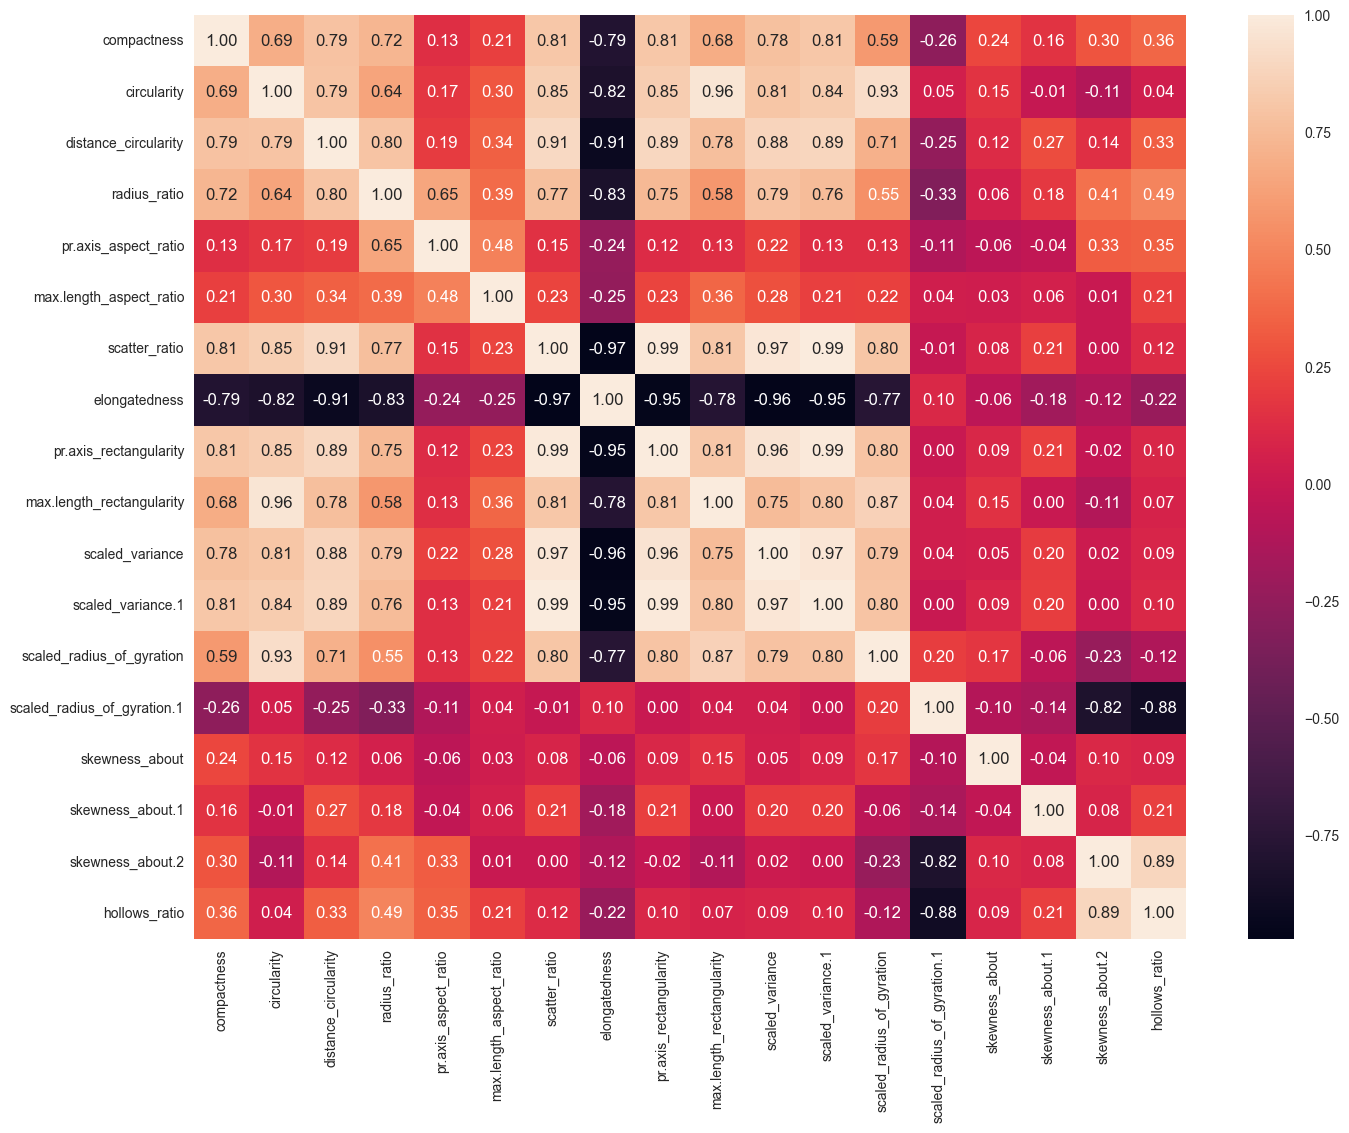

In [ ]:
# Plot Correlation Heatmap to Observe Features Relationships.
plt.figure(figsize = (16,12))
sns.heatmap(df.corr(), annot=True, fmt = '.2f')
plt.show()

**Results of the Data Preprocessing & Analysis Step:** 
* **41 missing value filled with median of the related feature.**
* **13 outlier removed from the dataset.**
* **Most of the features are highly correlated with each other.**

# Implementing Methods

### Normalization Process

In [ ]:
# Normalize the data frame values.
scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df)
df = pd.DataFrame(normalized_df, columns = df.columns)
 
# Display the shape of the data frame.
print(f'Data Frame Shape: {df.shape}\n')

# Display first 5 record of the data frame.
df.head()

Data Frame Shape: (833, 18)



,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.478261,0.576923,0.597222,0.500000,0.316456,0.150943,0.326797,0.457143,0.250000,0.585714,0.291139,0.233813,0.471698,0.183333,0.272727,0.390244,0.392857,0.533333
1,0.391304,0.307692,0.611111,0.250000,0.126582,0.132075,0.241830,0.542857,0.166667,0.357143,0.253165,0.175060,0.308176,0.216667,0.409091,0.341463,0.464286,0.600000
2,0.673913,0.653846,0.916667,0.709459,0.240506,0.150943,0.620915,0.171429,0.500000,0.571429,0.588608,0.540767,0.698113,0.233333,0.636364,0.219512,0.428571,0.500000
3,0.434783,0.307692,0.583333,0.371622,0.202532,0.132075,0.209150,0.571429,0.166667,0.357143,0.189873,0.149880,0.113208,0.066667,0.272727,0.243902,0.821429,0.866667
4,0.739130,0.423077,0.916667,0.459459,0.037975,0.075472,0.934641,0.000000,0.916667,0.728571,0.949367,0.926859,0.974843,0.433333,0.227273,0.219512,0.178571,0.066667


**I normalized all the columns into 0-1 range, because normalization is used to eliminate redundant data and ensures that good-quality clusters are generated which can improve the efficiency of clustering algorithms.**

## Clustering with All Features

### K-Means Clustering

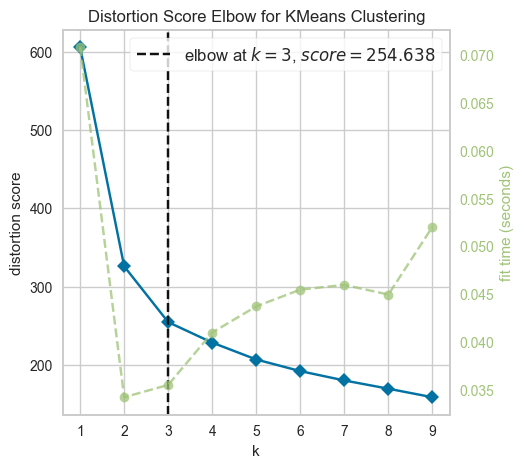

In [ ]:
# Elbow Method to determine optimal number of clusters.
plt.figure(figsize=(5,5))
KElbowVisualizer(KMeans(), k=(1, 10)).fit(df).show()
plt.show()

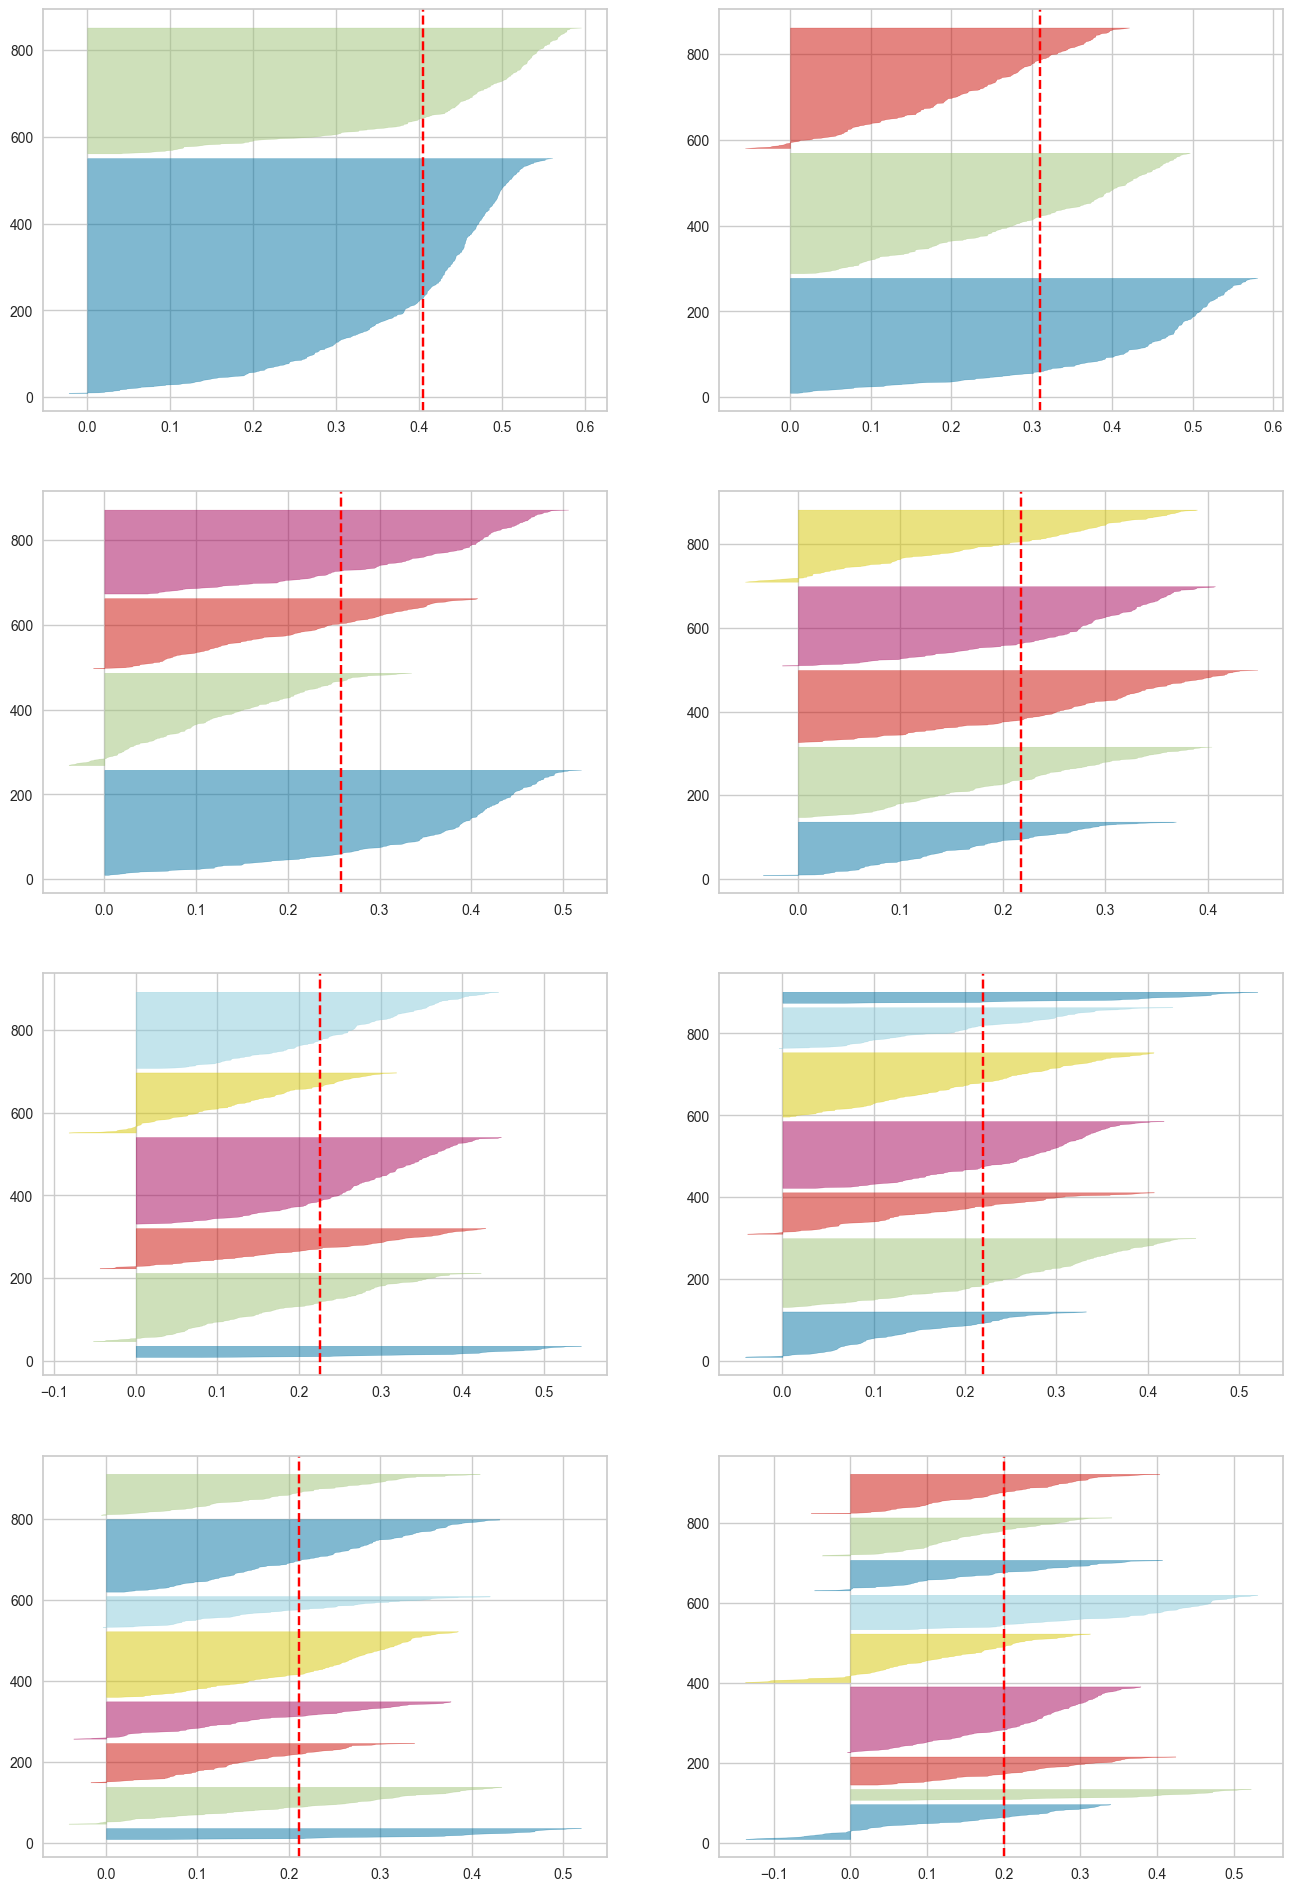

In [ ]:
# Silhouette Graph to Evaluate Clustering Performance.
fig, ax = plt.subplots(4, 2, figsize=(16,24))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    SilhouetteVisualizer(KMeans(n_clusters=i), colors='yellowbrick', ax=ax[divmod(i, 2)[0] - 1][divmod(i, 2)[1]]).fit(df) 

**Elbow and Silhouette methods demonstrate the 3 cluster is optimal.**

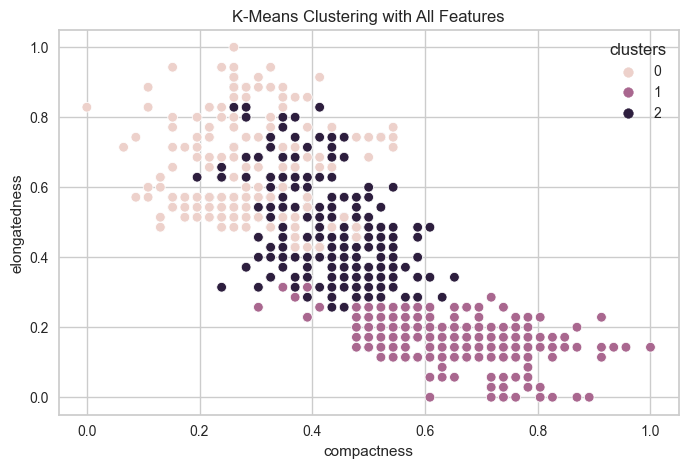

In [ ]:
# Initialize K-Means model with 3 cluster.
kmeans = KMeans(n_clusters= 3)
 
# Cluster the dataset.
kmeans.fit_predict(df)

# Add cluster label to copied original data frame.
kmeans_df = df.copy()
kmeans_df['clusters'] = kmeans.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=kmeans_df, x="compactness", y="elongatedness", hue="clusters")
plt.title('K-Means Clustering with All Features')
plt.show()

In [ ]:
# Silhouette Scores to Evaluate Clustering Performance.
for i in range(2, 10):
    model = KMeans(n_clusters = i)
    model.fit(df)
    pred = model.predict(df)
    score = silhouette_score(df, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(i, score))

Silhouette Score for k = 2: 0.405
Silhouette Score for k = 3: 0.311
Silhouette Score for k = 4: 0.254
Silhouette Score for k = 5: 0.218
Silhouette Score for k = 6: 0.226
Silhouette Score for k = 7: 0.211
Silhouette Score for k = 8: 0.204
Silhouette Score for k = 9: 0.201


### Agglomerative Clustering

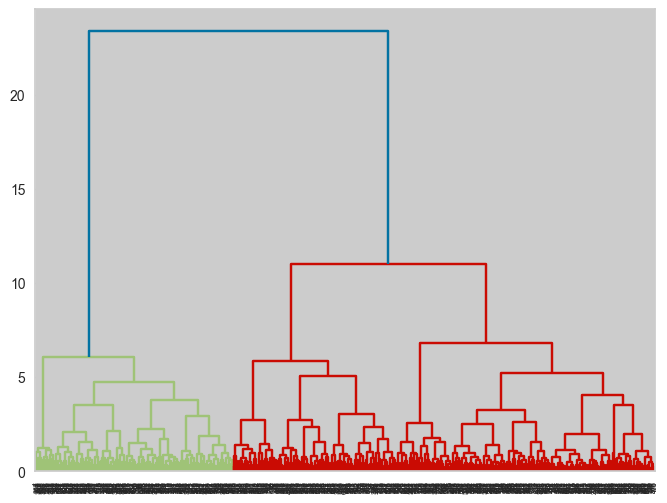

In [ ]:
# Plot dendrogram to determine optimal cluster count.
plt.figure(figsize=(8, 6))
dendrogram = sch.dendrogram(sch.linkage(df, method='ward'))
plt.show()

**Dendrogram method demonstrates the 3 cluster is optimal.**

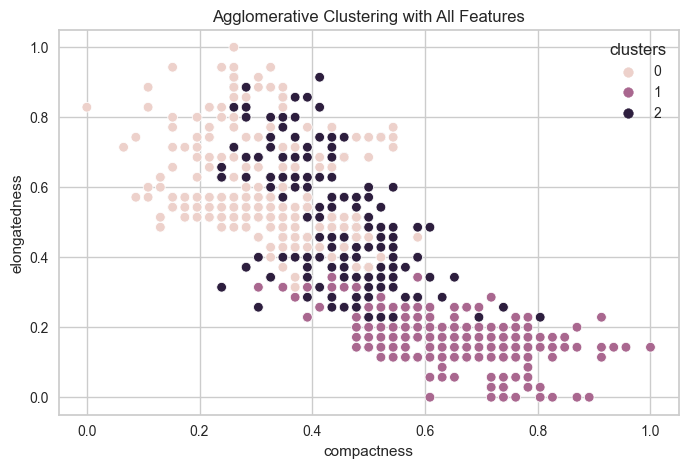

In [ ]:
# Initialize the Agglomerative model with 3 clusters.
agglomerative = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

# Predict the labels of clusters.
agglomerative.fit(df)

# Add cluster label to copied original data frame.
agglomerative_df = df.copy()
agglomerative_df['clusters'] = agglomerative.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=agglomerative_df, x="compactness", y="elongatedness", hue="clusters")
plt.title('Agglomerative Clustering with All Features')
plt.show()

In [ ]:
# Silhouette Scores to Evaluate Clustering Performance.
for i in range(2, 10):
    model = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    pred = model.fit_predict(df)
    score = silhouette_score(df, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(i, score))

Silhouette Score for k = 2: 0.402
Silhouette Score for k = 3: 0.286
Silhouette Score for k = 4: 0.241
Silhouette Score for k = 5: 0.206
Silhouette Score for k = 6: 0.185
Silhouette Score for k = 7: 0.175
Silhouette Score for k = 8: 0.189
Silhouette Score for k = 9: 0.164


### DBSCAN Clustering

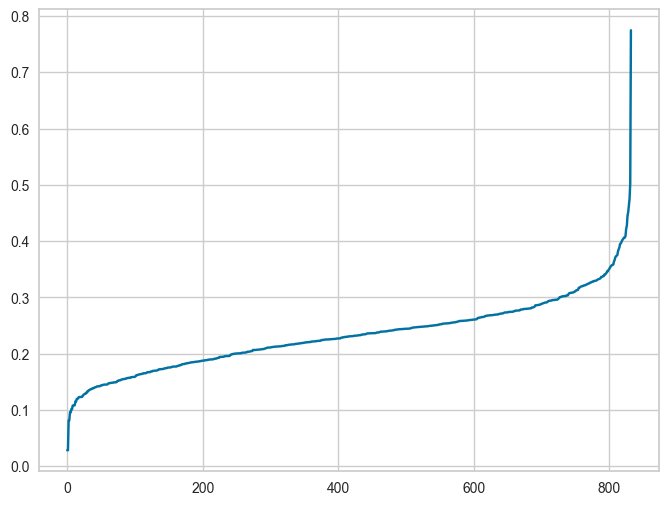

In [ ]:
# Plot epsilon graph.
neighbors = NearestNeighbors(n_neighbors=3).fit(df)
distances, indices = neighbors.kneighbors(df)

# Sort and plot the distances results
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.show()

**Epsilon graph demonstrates the 0.44 is the optimal epsilon value for 3-nearest neighbor.**

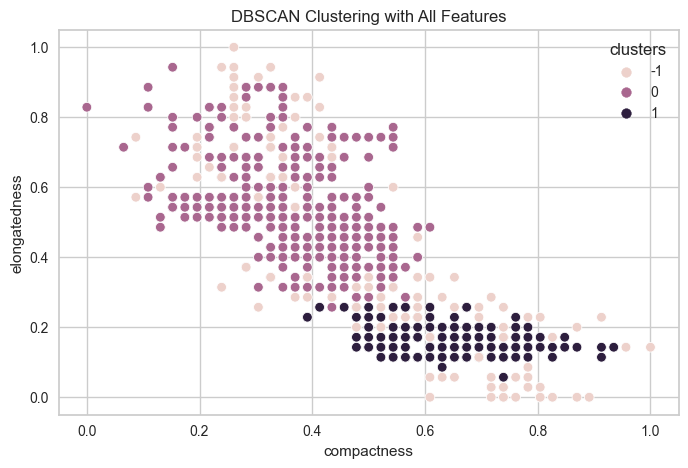

In [ ]:
# Initialize model with 3 cluster.
dbscan = DBSCAN(eps=0.44, min_samples= 18*2) 

# Cluster the dataset.
dbscan.fit(df)

# Add cluster label to copied original data frame.
dbscan_df = df.copy()
dbscan_df['clusters'] = dbscan.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=dbscan_df, x="compactness", y="elongatedness", hue="clusters")
plt.title('DBSCAN Clustering with All Features')
plt.show()

In [ ]:
# Silhouette Score of DBSCAN.
model = DBSCAN(eps=0.44,min_samples=36)
pred = model.fit_predict(df)
score = silhouette_score(df, pred)
print(f'Silhouette Score for k = 3: {score:.3f}')

Silhouette Score for k = 3: 0.262


## Clustering with Feature Selection

### Feature Selection with PCA

In [ ]:
# Select features which represents the %95 of the original data frame.
features = PCA(n_components = 0.95).fit_transform(df)

# Build an dataframe from selected features.
feature_df = pd.DataFrame(features)

# Change name of the columns.
for name in feature_df.columns:
    feature_df.rename(columns={name: f'PCA{name + 1}'}, inplace=True)
    
# Display the shape of the selected features data frame.
print(f'Feature Data Frame Shape: {feature_df.shape}')

# Display the first 5 record of the new data frame.
feature_df.head()

Feature Data Frame Shape: (833, 6)


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
0,0.049210,0.002777,0.020148,-0.004358,-0.231125,0.142193
1,-0.338375,0.113864,0.066365,0.146720,-0.076610,-0.069752
2,0.788632,-0.047765,0.270563,0.146600,0.149346,0.099336
3,-0.375222,0.589410,0.094155,-0.095835,-0.074964,-0.107032
4,1.218816,-0.726706,-0.180141,0.013322,0.435550,-0.296551


### K-Means Clustering

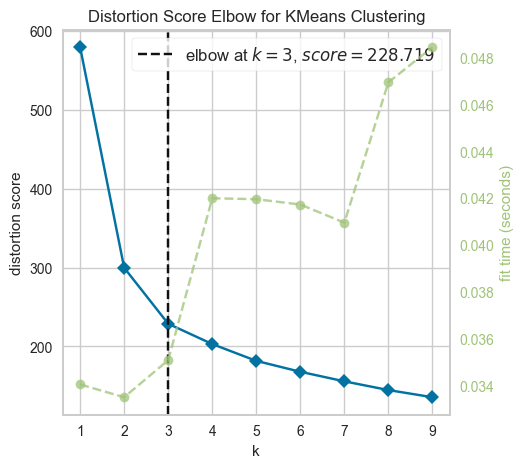

In [ ]:
# Elbow Method to determine optimal number of clusters.
plt.figure(figsize=(5,5))
KElbowVisualizer(KMeans(), k=(1, 10)).fit(feature_df).show()
plt.show()

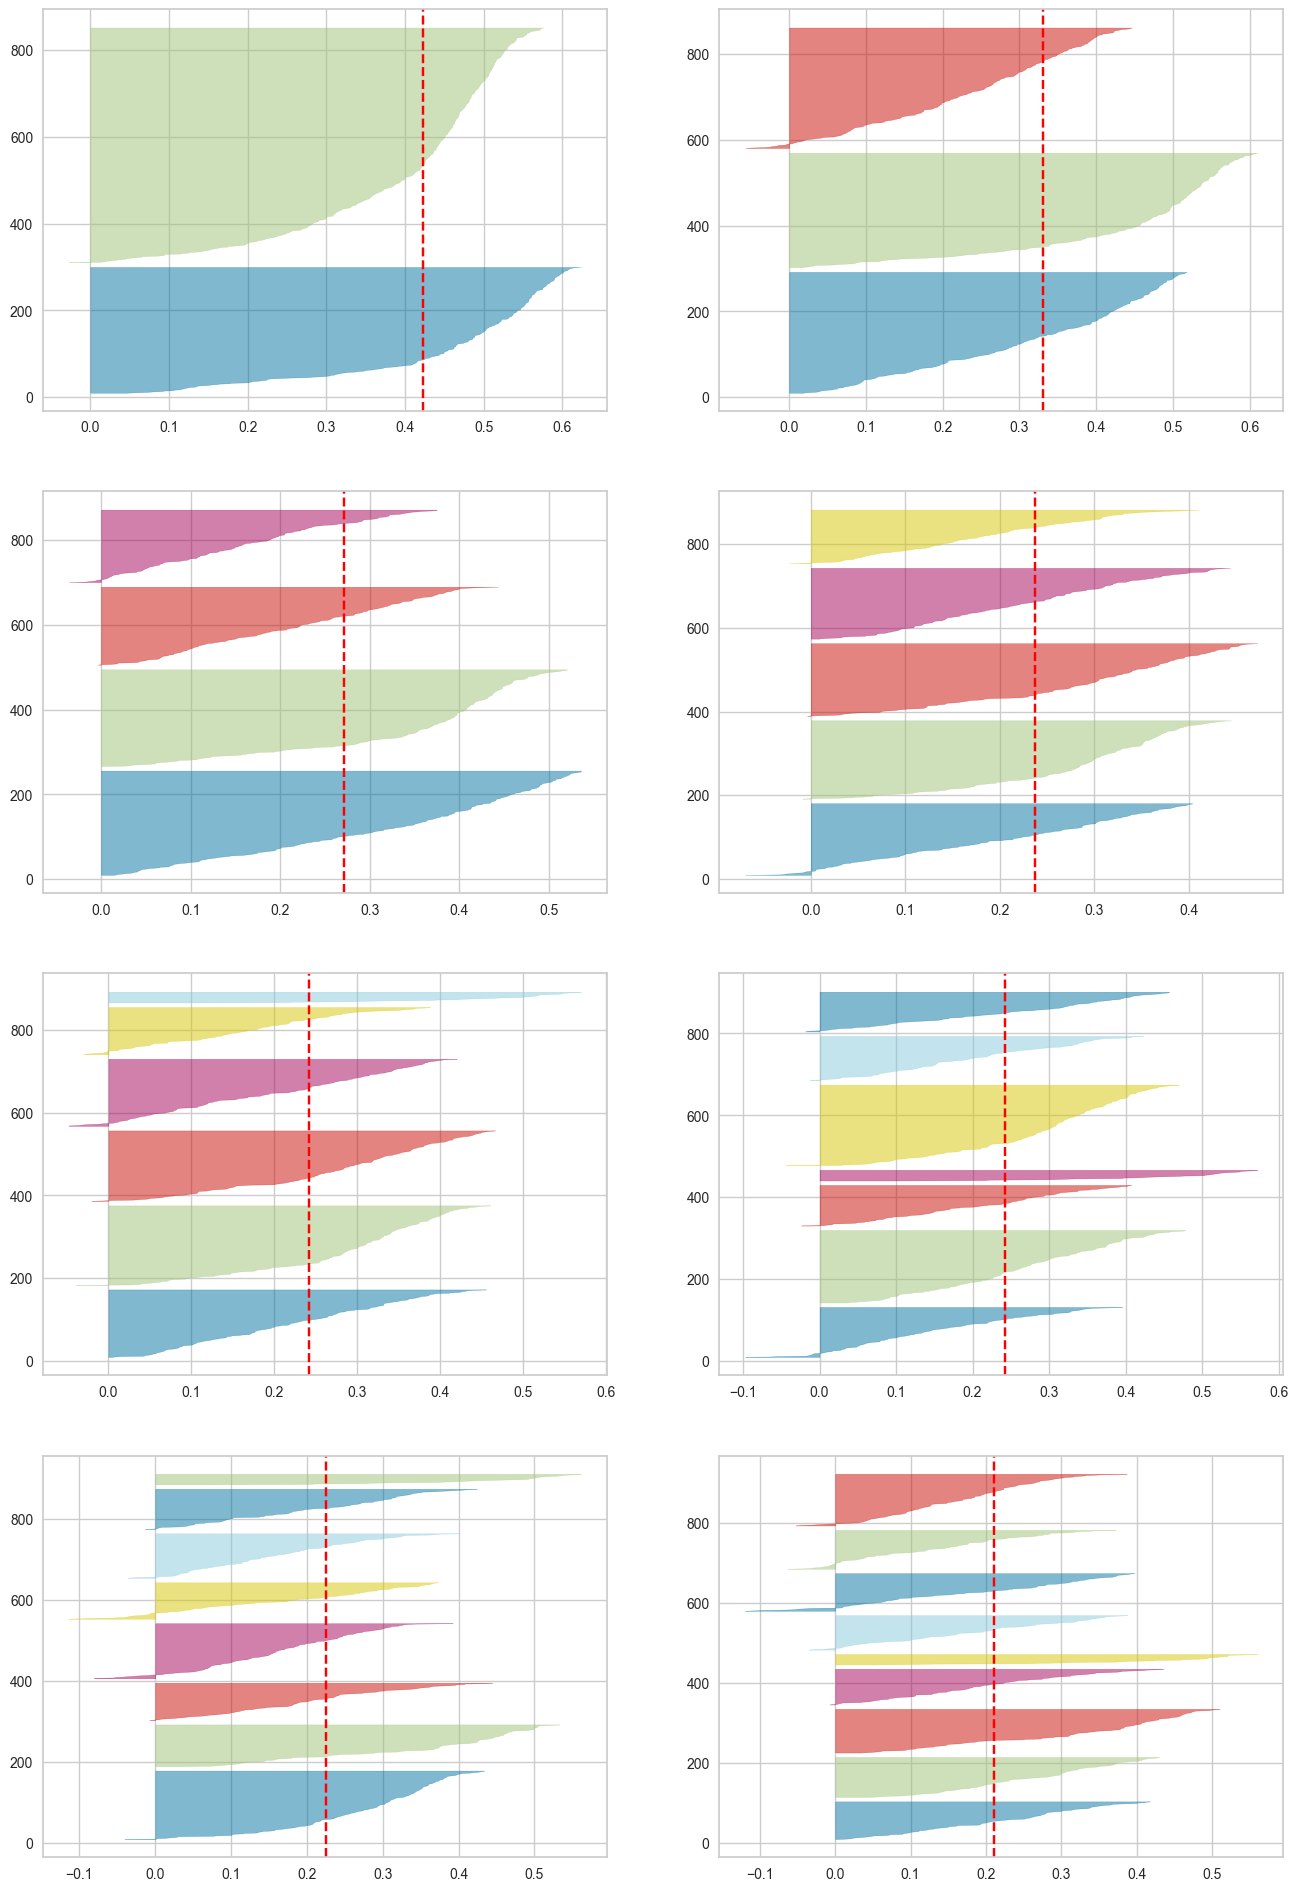

In [ ]:
# Silhouette Graph to Evaluate Clustering Performance.
fig, ax = plt.subplots(4, 2, figsize=(16,24))
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    SilhouetteVisualizer(KMeans(n_clusters=i), colors='yellowbrick', ax=ax[divmod(i, 2)[0] - 1][divmod(i, 2)[1]]).fit(feature_df) 

**Elbow and Silhouette method demonstrate the 3 cluster is optimal.**

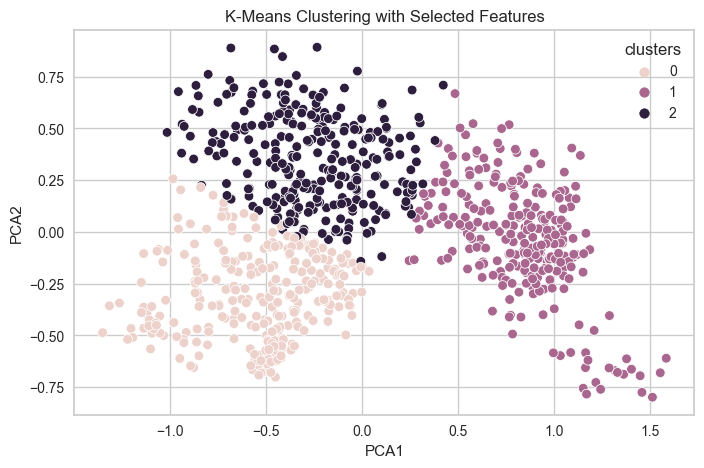

In [ ]:
# Initialize K-Means model with 3 cluster.
selected_kmeans = KMeans(n_clusters= 3)
 
# Cluster the dataset.
selected_kmeans.fit_predict(feature_df)

# Add cluster label to copied original data frame.
selected_kmeans_df = feature_df.copy()
selected_kmeans_df['clusters'] = selected_kmeans.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=selected_kmeans_df, x="PCA1", y="PCA2", hue="clusters")
plt.title('K-Means Clustering with Selected Features')
plt.show()

In [ ]:
# Silhouette Scores to Evaluate Clustering Performance.
for i in range(2, 10):
    model = KMeans(n_clusters = i)
    model.fit(feature_df)
    pred = model.predict(feature_df)
    score = silhouette_score(feature_df, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(i, score))

Silhouette Score for k = 2: 0.423
Silhouette Score for k = 3: 0.330
Silhouette Score for k = 4: 0.274
Silhouette Score for k = 5: 0.237
Silhouette Score for k = 6: 0.241
Silhouette Score for k = 7: 0.224
Silhouette Score for k = 8: 0.221
Silhouette Score for k = 9: 0.211


### Agglomerative Clustering

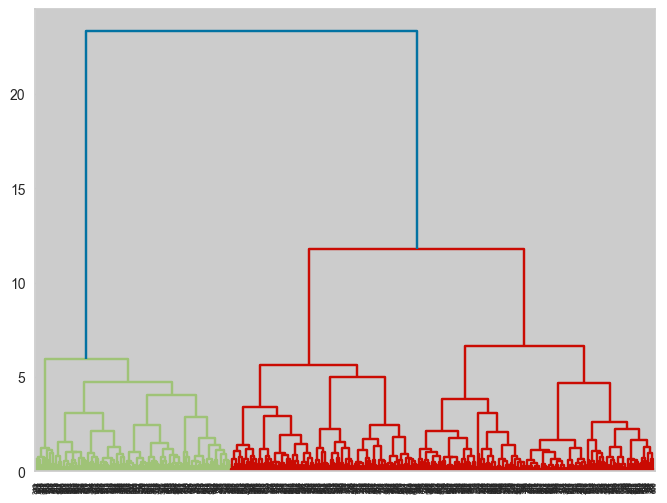

In [ ]:
# Plot dendrogram to determine optimal cluster count.
plt.figure(figsize=(8, 6))
dendrogram = sch.dendrogram(sch.linkage(feature_df, method='ward'))
plt.show()

**Dendrogram demonstrates the 3 cluster is optimal.**

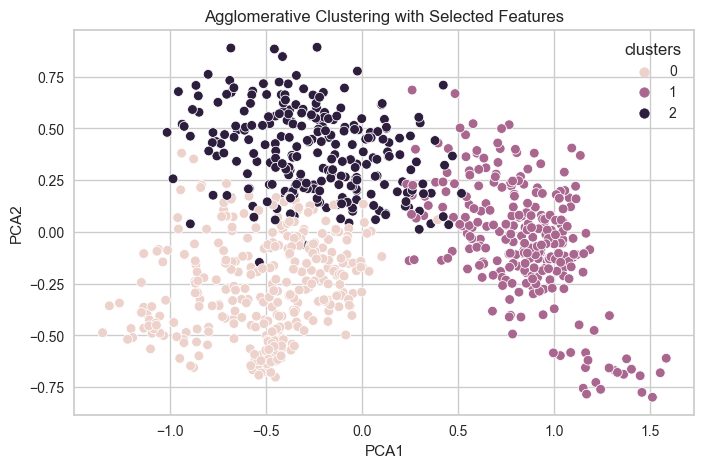

In [ ]:
# Initialize the Agglomerative model with 3 clusters.
selected_agglomerative = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

# Predict the labels of clusters.
selected_agglomerative.fit(feature_df)

# Add cluster label to copied original data frame.
selected_agglomerative_df = feature_df.copy()
selected_agglomerative_df['clusters'] = selected_agglomerative.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=selected_agglomerative_df, x="PCA1", y="PCA2", hue="clusters")
plt.title('Agglomerative Clustering with Selected Features')
plt.show()

In [ ]:
# Silhouette Scores to Evaluate Clustering Performance.
for i in range(2, 10):
    model = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    pred = model.fit_predict(feature_df)
    score = silhouette_score(feature_df, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(i, score))

Silhouette Score for k = 2: 0.419
Silhouette Score for k = 3: 0.315
Silhouette Score for k = 4: 0.249
Silhouette Score for k = 5: 0.216
Silhouette Score for k = 6: 0.212
Silhouette Score for k = 7: 0.204
Silhouette Score for k = 8: 0.186
Silhouette Score for k = 9: 0.176


### DBSCAN CLUSTERING

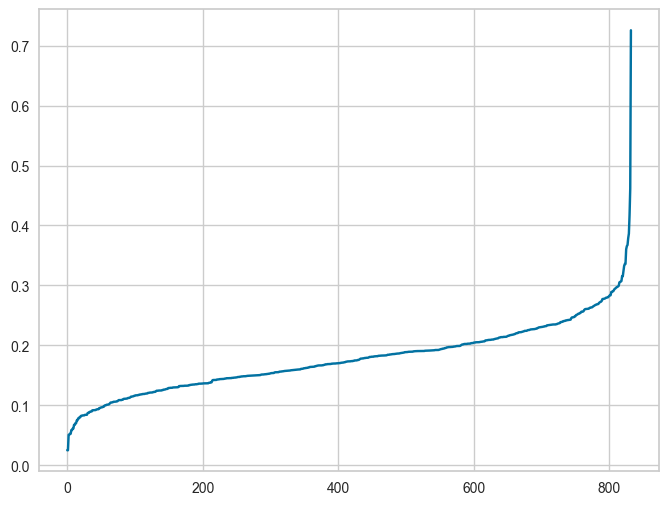

In [ ]:
# Plot epsilon graph.
selected_neighbors = NearestNeighbors(n_neighbors=3).fit(feature_df)
distances, indices = selected_neighbors.kneighbors(feature_df)

# Sort and plot the distances results
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.show()

**Epsilon Graph demonstrates the 0.3 epsilon is the optimal.**

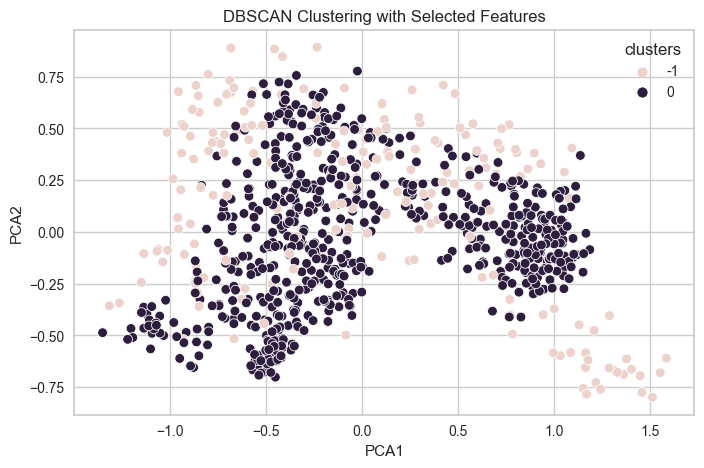

In [ ]:
# Initialize model with 3 cluster.
dbscan = DBSCAN(eps=0.3, min_samples=6*2) 

# Cluster the dataset.
dbscan.fit(feature_df)

# Add cluster label to copied original data frame.
selected_dbscan_df = feature_df.copy()
selected_dbscan_df['clusters'] = dbscan.labels_

# Plot clusters.
plt.figure(figsize=(8, 5))
sns.scatterplot(data=selected_dbscan_df, x="PCA1", y="PCA2", hue="clusters")
plt.title('DBSCAN Clustering with Selected Features')
plt.show()

In [ ]:
# Silhouette Score of DBSCAN.
model = DBSCAN(eps=0.3,min_samples=12)
pred = model.fit_predict(feature_df)
score = silhouette_score(feature_df, pred)
print(f'Silhouette Score for k = 3: {score:.3f}')

Silhouette Score for k = 3: 0.108


# REPORT

## Overview of the Problem
**In this assignment, I evaluated different clustering methods on the same dataset. This evaluation is based on the observation of clustering performance of algorithms depending on the effects of normalization and feature selection.**

## Preprocessing & Data Analysis
1. **I check data types of the features as a preliminary step of the preprocessing stage. The dataset contains only numerical features, so I do not need to do any categorical feature operation.**
2. **I check the NaN values in the dataset by plotting the BarH graph. 14 features contained NaN values in the dataset but there were 6 outliers at most for these features, so I fill all of these missing values with a median of the related features.**
3. **As a continuation of missing value filling, I check the outliers in the dataset by plotting Boxplot and Histogram. Five features which are radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scaled_variance, scaled_radius_of_gyration.1 contain certain outliers according to these plots. Other features are left, right or symmetric skewed and do not contain certain outliers.**
4. **I counted the outliers in these features by plotting BarH graph. These features are contain at most 8 outlier, 8 outlier in 800+ data point can considered as too low percentage so I deleted these outliers directly.**
5. **As a final step of preprocessing and data analysis part, I plot the Correlation Heatmap of features to observe feature relationships. According to this heatmap, most of the features are highly correlated with each other. Based on this observation, weighted clustering algorithms act poor performance for this dataset.**

## Implementing Methods

### Feature Normalization
**As domain knowledge, datasets are built upon different features and this features units are different from each other. These unit differences create redundant data and ensure low-quality clusters. Depending on this domain knowledge, I normalized my features into the 0-1 range to eliminate redundant data to create good-quality clusters are generated which can improve the efficiency of clustering algorithms.**

### Feature Selection
**I select features with PCA method. I determine the n_components parameters as 0.95, this means PCA automatically select features which represents the %95 of the original features.**

### Experiment Results:
* **K-Means Clustering with All Features on 3 cluster: 0.311**
* **K-Means Clustering with Selected Features on 3 cluster: 0.330**
* **Agglomerative Clustering with All Features on 3 cluster: 0.286**
* **Agglomerative Clusteirng with Selected Features on 3 cluster: 0.315**
* **DBSCAN Clustering with All Features on 3 cluster: 0.262**
* **DBSCAN Clustering with Selected Features on 2 cluster: 0.108**

### K-Means Clustering
**In both of the experiments which are all features included and features selection, I use elbow and silhouette methods to determine optimal cluster count. Optimal cluster count decided as 3 for both of these experiments. As a results of these experiments:**
* **As shown in example cluster graphs for both of the models, feature selected k-means cluster model clustering the data point more smooth.**
* **Feature selection increased the silhouette scores. That means, feature selection affects the k-means clustering positively because as I mentioned in correlation part, PCA reduces the correlation between the feature while feature selection so performance of clustering is increasing.**

### Agglomerative Clustering
**In both of the experiments which are all features included and features selection, I use dendrogram method to determine optimal cluster count. Optimal cluster count decided as 3 for both of these experiments. As a results of these experiments:**
* **As shown in example cluster graphs for both of the models, Agglomerative models clustering performances are worst than K-means for this dataset because inter-class difference of clusters is too low for Agglomerative models. Also, feature selected Agglomerative model still better clustering than all features included Agglomerative model.**
* **Feature selection increased the silhouette scores for Agglomerative clustering too much. As mentioned in the K-means Clustering part, decreasing on the feature correlation while feature selection increase the clustering performance for Agglomerative Clustering.**

### DBSCAN Clustering
**In both of the experiments which are all features included and features selection, I use epsilon method to determine optimal threshold point. Model decides optimal cluster count based on this threshold value and minimum sample point hyperparameters. As a results of these experiments:**
* **While all features included DBSCAN model chooses 3 cluster, feature selected DBSCAN model choosed 2 cluster. When we compare these two models example cluster graphs, intra-class of the feature selected model is too low. So, feature selection affected the DBSCAN clustering badly. Also, DBSCAN shows worst performance than both of the K-Means and Agglomerative for all experiments. Hence, I can say the density based clustering is not appropriate for this dataset.**
* **Feature selection decreased the silhouette scores because while we choosing features with PCA, we also decrease the correlation between features so density based models can not work good because of this decreasing in correlation.**